<a href="https://colab.research.google.com/github/Dhanyabahadur/Resume-Classifier/blob/main/Resume%20Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [2]:
import os
import numpy as np
np.random.seed(42)
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import os
import random
random.seed(42)
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg
from PIL import Image

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import torch
torch.manual_seed(42)
import torch.nn as nn
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader
from torchsummary import summary

g = torch.Generator()
g.manual_seed(42)

import warnings
warnings.filterwarnings('ignore')

Please download the dataset from the following link and save it to your Google Drive or local storage. After downloading, update the file path in the code accordingly: https://drive.google.com/drive/folders/1bO379__wbrUWqvioOlN3ZxNABNOnyjvv?usp=sharing


In [4]:
train_dir = '/content/drive/MyDrive/Data/train_data/'
valid_dir =   '/content/drive/MyDrive/Data/val_data/'
test_dir = '/content/drive/MyDrive/Data/test_data/'

CLASS_NAMES = os.listdir(train_dir)
print(f"Folders in train directory: {os.listdir(train_dir)}")
print(f"Folders in validation directory: {os.listdir(valid_dir)}")
print(f"Folders in test directory: {os.listdir(test_dir)}")

Folders in train directory: ['Resume', 'NonResume']
Folders in validation directory: ['NonResume', 'Resume']
Folders in test directory: ['Resume', 'NonResume']


In [5]:
# Number of images in each directory
resume_dir = 'Resume'
nonresume_dir = 'NonResume'

print(f"Number of resume images in training data: {len(os.listdir(train_dir + '/' + resume_dir))}")
print(f"Number of non resume images in training data: {len(os.listdir(train_dir + '/' + nonresume_dir))}")
print(f"Number of resume images in validation data: {len(os.listdir(valid_dir + '/' + resume_dir))}")
print(f"Number of non resume images in validation data: {len(os.listdir(valid_dir + '/' + nonresume_dir))}")
print(f"Number of resume images in test data: {len(os.listdir(test_dir + '/' + resume_dir))}")
print(f"Number of non resume images in test data: {len(os.listdir(test_dir + '/' + nonresume_dir))}")

Number of resume images in training data: 390
Number of non resume images in training data: 390
Number of resume images in validation data: 30
Number of non resume images in validation data: 30
Number of resume images in test data: 30
Number of non resume images in test data: 30


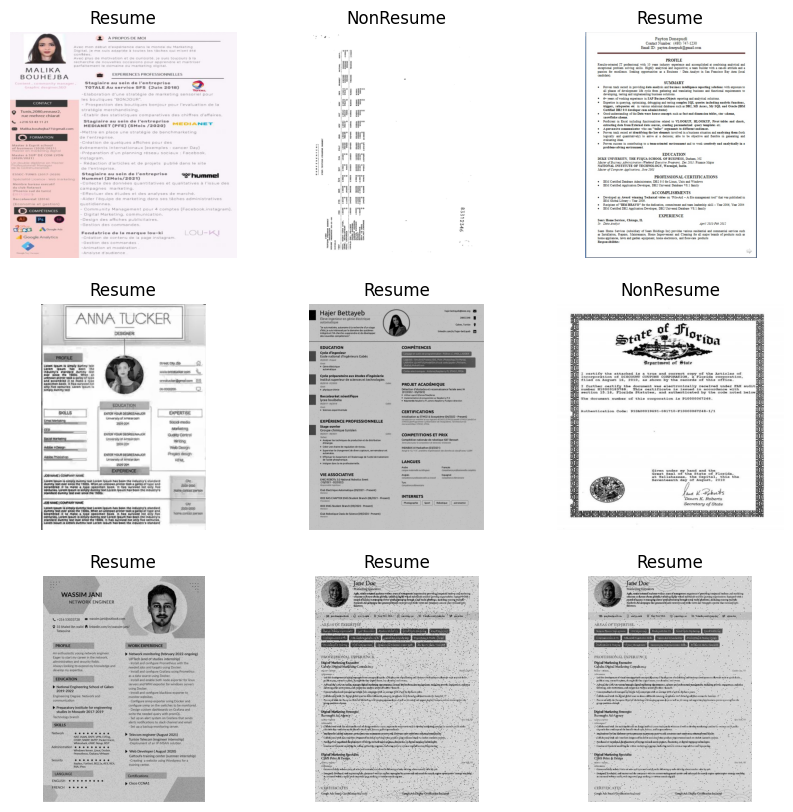

In [6]:
# function to show random images
def show_random_images(data_dir, num_images):
  class_names = os.listdir(data_dir)
  num_rows = int(num_images ** 0.5)
  num_cols = int(num_images ** 0.5)
  fig, axarr = plt.subplots(num_rows, num_cols, figsize=(10,10))
  for i in range(num_rows):
    for j in range(num_cols):
      class_num = random.randint(0, len(class_names)-1)
      img_name = random.choice(os.listdir(os.path.join(data_dir, class_names[class_num])))
      img_path = os.path.join(data_dir, class_names[class_num], img_name)
      img = mpimg.imread(img_path)
      axarr[i, j].imshow(img, cmap='gray')
      axarr[i, j].set_title(class_names[class_num])
      axarr[i, j].axis('off')

  plt.show()

show_random_images(train_dir, 9)

### Transformation Steps

In image classification tasks, particularly when using a model like ResNet18, applying transformations to the dataset is crucial for enhancing the model's robustness and generalization capabilities. The transformations serve several purposes:

1. **Resizing**: Ensures all images have a consistent size, making it easier to batch them and feed them into the neural network.
2. **Random Horizontal Flip**: Introduces variation by flipping images horizontally, which helps the model generalize across different orientations.
3. **Color Jittering**: Simulates different lighting conditions by altering brightness, contrast, saturation, and hue, making the model more robust to color variations.
4. **Random Rotation**: Adds rotational variance to the images, enabling the model to recognize objects from different angles.
5. **Tensor Conversion**: Converts the image data into a tensor format required by PyTorch models.
6. **Normalization**: Centers and scales pixel values, which accelerates the model’s training process and ensures consistent input during validation.

These transformations are applied both during training and validation to ensure that the model learns effectively from diverse inputs and performs well in real-world scenarios.

In [7]:
image_transforms = {
    'train': transforms.Compose([
        transforms.Resize((512, 512)),                          # Resize images to a fixed size
        transforms.RandomHorizontalFlip(),                      # Randomly flip images horizontally
        transforms.ColorJitter(),                               # Apply random color adjustments
        transforms.RandomRotation(30),                          # Randomly rotate images by 30 degrees
        transforms.ToTensor(),                                  # Convert images to tensor format
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Normalize pixel values
    ]),

    'valid': transforms.Compose([
        transforms.Resize((512, 512)),                          # Resize images to a fixed size
        transforms.RandomHorizontalFlip(),                      # Randomly flip images horizontally
        transforms.ColorJitter(),                               # Apply random color adjustments
        transforms.RandomRotation(30),                          # Randomly rotate images by 30 degrees
        transforms.ToTensor(),                                  # Convert images to tensor format
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Normalize pixel values
    ])
}

In [8]:
# load data from specific directory and apply transformations
data = {
    'train' : datasets.ImageFolder(root=train_dir, transform = image_transforms['train']),
    'valid' : datasets.ImageFolder(root=valid_dir, transform=image_transforms['valid'])
}

print(f"length of training data : {(len(data['train']))}")
print(f"length of validation data : {(len(data['valid']))}")

length of training data : 780
length of validation data : 60


In [9]:
# Number of samples processed before updating the weights
BATCH_SIZE = 15
NUM_CLASSES = 2

# Loads data in batches of size batch_size and shuffles the data at each epoch to improve generalization.
train_loader = DataLoader(data['train'], batch_size = BATCH_SIZE, shuffle=True, generator=g)
valid_loader = DataLoader(data['valid'], batch_size = BATCH_SIZE, shuffle=True, generator=g)

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [11]:
# Loading pretrained weights of resnet18
model = models.resnet18(pretrained=True).to(device)
summary(model, (3, 512, 512))

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 221MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           9,408
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
         MaxPool2d-4         [-1, 64, 128, 128]               0
            Conv2d-5         [-1, 64, 128, 128]          36,864
       BatchNorm2d-6         [-1, 64, 128, 128]             128
              ReLU-7         [-1, 64, 128, 128]               0
            Conv2d-8         [-1, 64, 128, 128]          36,864
       BatchNorm2d-9         [-1, 64, 128, 128]             128
             ReLU-10         [-1, 64, 128, 128]               0
       BasicBlock-11         [-1, 64, 128, 128]               0
           Conv2d-12         [-1, 64, 128, 128]          36,864
      BatchNorm2d-13         [-1, 64, 128, 128]             128
             ReLU-14         [-1, 64, 1

In [12]:
# Freeze all layers except last one
for param in model.parameters():
  # disable gradient updates for all layers to prevenet them from training
  param.requires_grad = False

# number of features for the fully connected layer
num_features = model.fc.in_features

# replace model's fully connected (fc) layer witha new sequential layer
model.fc = nn.Sequential(
    nn.Linear(num_features, 512),  # Add a linear layer with 512 output features
    nn.ReLU(),                     # Apply ReLU activation for non-linearity
    nn.Dropout(p=0.5),             # Apply dropout to prevent overfitting
    nn.Linear(512, 256),           # add another layer with 256 output features
    nn.ReLU(),                     # Apply ReLU activation for non-linearity
    nn.Dropout(p=0.5),             # Apply dropout to prevent overfitting
    nn.Linear(256, 128),           # add another layer with 128 output features
    nn.ReLU(),                     # Apply ReLU activation for non-linearity
    nn.Dropout(p=0.5),             # Apply dropout to prevent overfitting
    nn.Linear(128, 64),            # add another layer with 64 output features
    nn.ReLU(),                     # Apply ReLU activation for non-linearity
    nn.Dropout(p=0.5),             # Apply dropout to prevent overfitting
    nn.Linear(64, NUM_CLASSES)     # final layer with output units equal to the number of classes
)

# move the model to specified device (GPU/CPU)
model = model.to(device)

In [13]:
# loss function
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.fc.parameters(), lr=0.01, weight_decay = 0.001, momentum=0.9)

In [14]:
# number of training epochs
num_epochs = 20

# list to store training and validation loss
train_losses = []
valid_losses = []

for epoch in range(num_epochs):
  # variables to accumulate loss values for training and validation
  train_loss = 0
  valid_loss = 0

  # set the model to training mode
  model.train()
  for images, labels in train_loader:
    # move training data to specified device
    images = images.to(device)
    labels = labels.to(device)
    optimizer.zero_grad()                        # reset gradients of model parameters
    outputs = model(images)                      # forward pass
    loss = criterion(outputs, labels)            # compute loss between predictions and true labels
    loss.backward()                              # Backward pass: compute gradients of the loss with respect to model parameters
    optimizer.step()                             # update the model parameters using the optimizer
    train_loss += loss.item() * images.size(0)   # accumulate the batch loss, scaled by the number of images in the batch
    train_loss /= len(train_loader.dataset)      # average training loss for the epoch
    train_losses.append(train_loss)              # store average training loss for this epoch

  model.eval()                                   # set the model to evaluation mode
  for images, labels in valid_loader:
    # move data to device
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)                      # Forward pass: compute model predictions for teh validation images
    loss = criterion(outputs, labels)            # Compute loss
    valid_loss += loss.item() * images.size(0)   # accumulate the batch loss, scaled by the number of images in the batch
    valid_loss /= len(valid_loader.dataset)      # average validation loss for the epoch
    valid_losses.append(valid_loss)

  print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, ValidLoss: {valid_loss:.4f}')

Epoch [1/20], Train Loss: 0.0126, ValidLoss: 0.1764
Epoch [2/20], Train Loss: 0.0125, ValidLoss: 0.1690
Epoch [3/20], Train Loss: 0.0086, ValidLoss: 0.0930
Epoch [4/20], Train Loss: 0.0089, ValidLoss: 0.0174
Epoch [5/20], Train Loss: 0.0016, ValidLoss: 0.0233
Epoch [6/20], Train Loss: 0.0090, ValidLoss: 0.0329
Epoch [7/20], Train Loss: 0.0199, ValidLoss: 0.1094
Epoch [8/20], Train Loss: 0.0041, ValidLoss: 0.0058
Epoch [9/20], Train Loss: 0.0027, ValidLoss: 0.0982
Epoch [10/20], Train Loss: 0.0079, ValidLoss: 0.0070
Epoch [11/20], Train Loss: 0.0017, ValidLoss: 0.1102
Epoch [12/20], Train Loss: 0.0002, ValidLoss: 0.0838
Epoch [13/20], Train Loss: 0.0034, ValidLoss: 0.0169
Epoch [14/20], Train Loss: 0.0018, ValidLoss: 0.0288
Epoch [15/20], Train Loss: 0.0012, ValidLoss: 0.0449
Epoch [16/20], Train Loss: 0.0029, ValidLoss: 0.0212
Epoch [17/20], Train Loss: 0.0070, ValidLoss: 0.0671
Epoch [18/20], Train Loss: 0.0033, ValidLoss: 0.0054
Epoch [19/20], Train Loss: 0.0026, ValidLoss: 0.0478
Ep

### Evaluation on Train and Validation Data

In [15]:
# set the modle to evaluation mode, disables dropout, batch norm and others
model.eval()

# disable gradient computation as we're only evaluating the model
with torch.no_grad():
  train_correct = 0
  train_total = 0
  y_pred_train = []
  y_true_train = []
  for images, labels in train_loader:
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)                                                                    # perform a forward pass to get model predictions
    train_, train_predicted = torch.max(outputs.data, 1)                                       # get the predicted class with highest score
    train_total += labels.size(0)                                                              # update total count of training samples
    train_correct += (train_predicted == labels).sum().item()                                  # Accumulate the count of correct predictions
    y_pred_train.extend(train_predicted.cpu().numpy())                                         # Store predicted labels for further analysis
    y_true_train.extend(labels.cpu().numpy())                                                  # store true labels for further analysis
  print(f"Train accuracy of the model on train images : {(100 * train_correct / train_total)}")

  # do the same for validation set
  valid_correct = 0
  valid_total = 0
  y_pred_valid = []
  y_true_valid = []
  for images, labels in valid_loader:
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    valid_, valid_predicted = torch.max(outputs.data, 1)
    valid_total += labels.size(0)
    valid_correct += (valid_predicted == labels).sum().item()
    y_pred_valid.extend(valid_predicted.cpu().numpy())
    y_true_valid.extend(labels.cpu().numpy())
  print(f"Valid accuracy of the model on valid images : {(100 * valid_correct / valid_total)}")

Train accuracy of the model on train images : 97.56410256410257
Valid accuracy of the model on valid images : 96.66666666666667


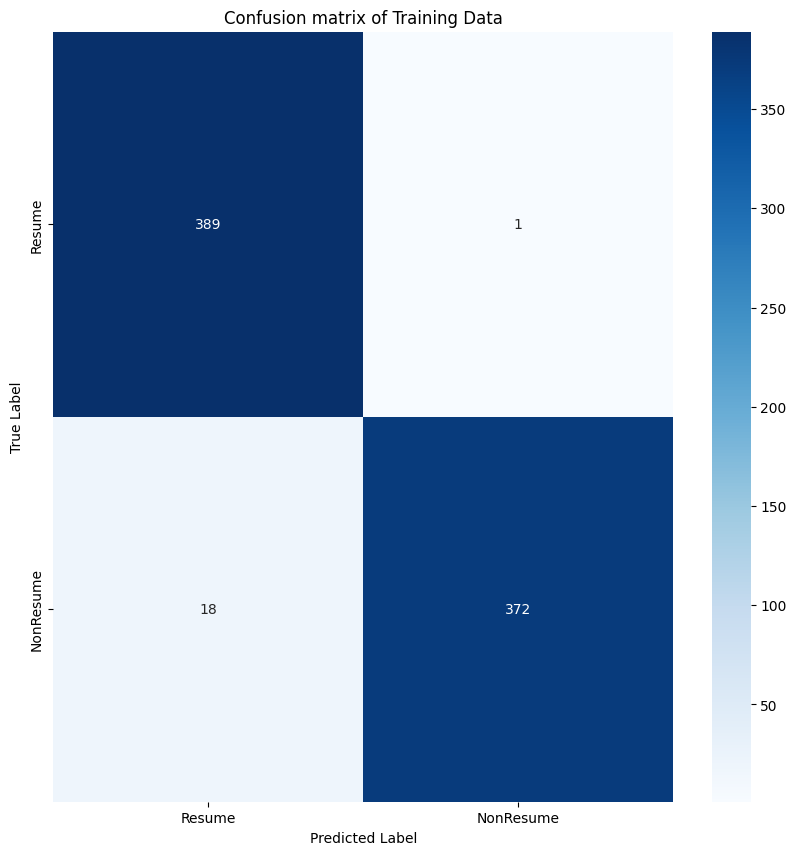

              precision    recall  f1-score   support

      Resume       0.96      1.00      0.98       390
   NonResume       1.00      0.95      0.98       390

    accuracy                           0.98       780
   macro avg       0.98      0.98      0.98       780
weighted avg       0.98      0.98      0.98       780



In [16]:
cm = confusion_matrix(y_true_train, y_pred_train)                                                    # confusion matrix to evaluate the accuracy of classifications
plt.figure(figsize=(10,10))                                                                          # set figure size
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES) # plot confusion matrix as heatmap with annotations, using class names for labels
plt.title('Confusion matrix of Training Data')                                                                        # title of plot
plt.ylabel('True Label')                                                                             # label y axis as "True Label"
plt.xlabel('Predicted Label')                                                                        # label x axis as "Predicted Label"
plt.show()

print(classification_report(y_true_train, y_pred_train, target_names=CLASS_NAMES))                   # classification report with precision, recall and F1-score for each class

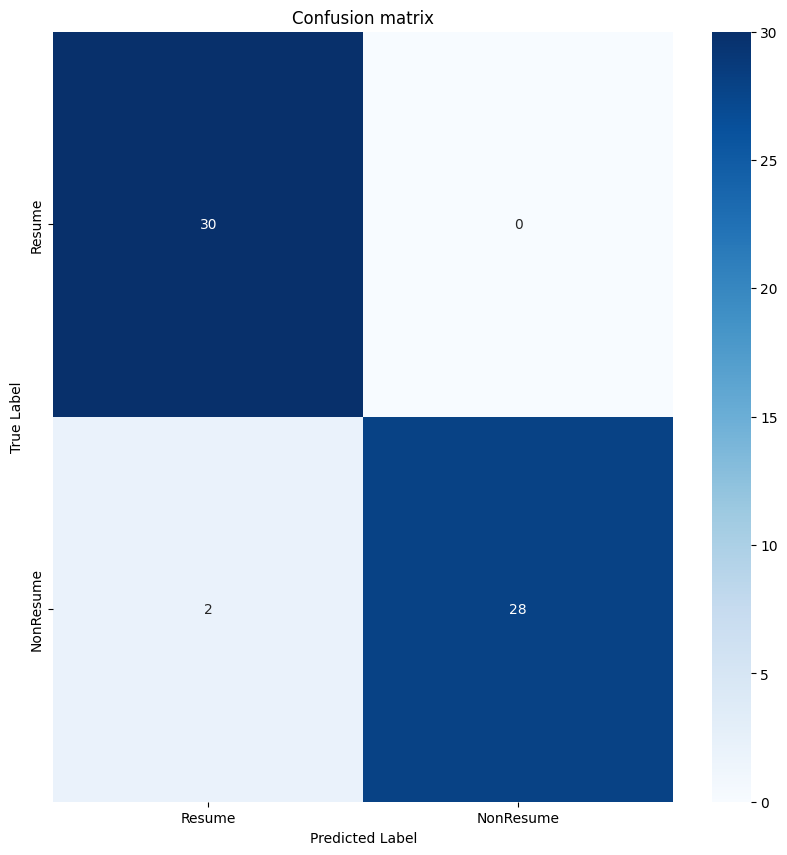

              precision    recall  f1-score   support

      Resume       0.94      1.00      0.97        30
   NonResume       1.00      0.93      0.97        30

    accuracy                           0.97        60
   macro avg       0.97      0.97      0.97        60
weighted avg       0.97      0.97      0.97        60



In [17]:
cm = confusion_matrix(y_true_valid, y_pred_valid)
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.title('Confusion matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

print(classification_report(y_true_valid, y_pred_valid, target_names=CLASS_NAMES))

In [18]:
#@title Evaluation on Test set

# transformation for the test set
test_transforms = transforms.Compose([
    transforms.Resize((512, 512)),                         # Resize images to 512x512 pixels
    transforms.ToTensor(),                                 # Convert images to tensor format
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]) # Normalize pixel values
])

# load test dataset with the defined transformations
test_data = datasets.ImageFolder(test_dir, transform=test_transforms)
# create a DataLoader for the test data with a batch size of 20 and shuffle enabled
test_loader = DataLoader(test_data, batch_size=20, shuffle=True, generator=g)

# set the model to evaluation mode (disables dropout, batch norm, etc.)
model.eval()

# disable gradient computation as we are evaluating the model
with torch.no_grad():
  correct = 0
  total = 0
  y_pred = []
  y_true = []
  for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)                                                           # perform a forward pass to get model predictions
    _, predicted = torch.max(outputs.data, 1)                                         # Get the predicted class with the highest score
    total += labels.size(0)                                                           # update the total count of test samples
    correct += (predicted == labels).sum().item()                                     # Accumulate teh count of correct predictions
    y_pred.extend(predicted.cpu().numpy())                                            # store predicted labels for further analysis
    y_true.extend(labels.cpu().numpy())                                               # store true labels for further analysis
  print(f"Test accuracy of the model on the test images : {(100 * correct / total)}") # Test accuracy as percentage

Test accuracy of the model on the test images : 90.0


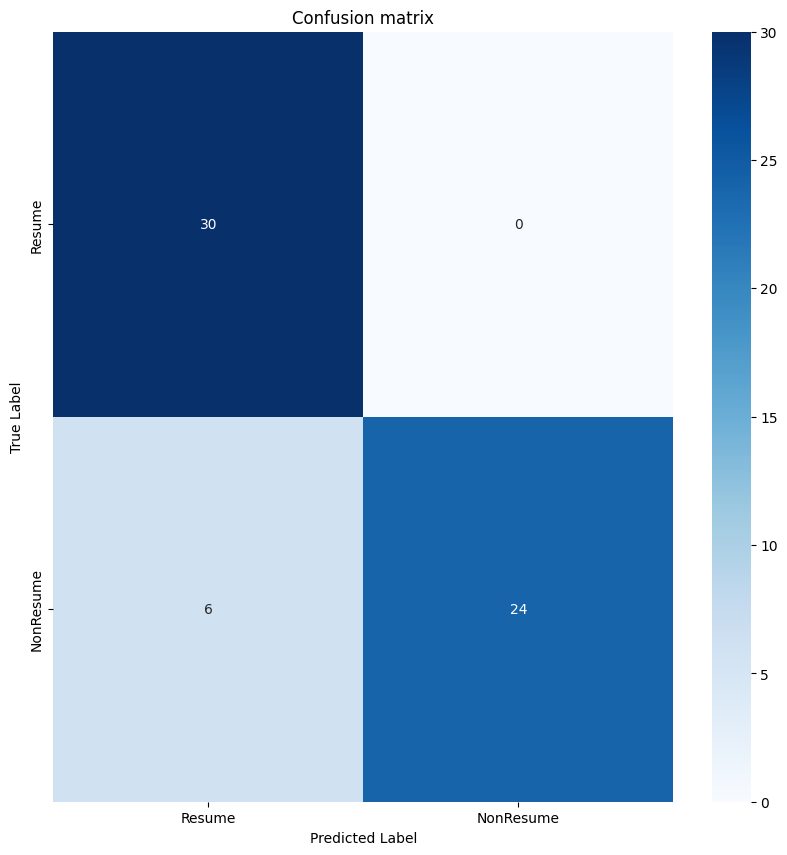

              precision    recall  f1-score   support

      Resume       0.83      1.00      0.91        30
   NonResume       1.00      0.80      0.89        30

    accuracy                           0.90        60
   macro avg       0.92      0.90      0.90        60
weighted avg       0.92      0.90      0.90        60



In [19]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.title('Confusion matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))